In [1]:
wave_param = 0

In [2]:
# Parameters
wave_param = 2


# Preprocessing

Each wave must be preprocessed. This will include:
- Assigning labels according to the CESD-10 reporting scale
- Discretizing/classing continuous variables
- Feature Selection/Engineering
- Normalisation/Scaling

## Data Preparation

This includes:
1. Collecting each wave's .csv file
2. Renaming columns to make them more useable
3. Type fixing (Eg. Changing Date to datetime)
4. Incomplete data dropping (For the purpose of this Research, we only include data from participants who were 'Successfully Interviewed')

**This notebook requires the user to specify which wave number to preprocess at the beginning of the file. Thus, for all 5 waves it must be run separately. Thereafter, the labeller.py file must be run to apply labels and generate labelled csv files.**

In [3]:
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import plotter
import importlib

from sklearn.utils import resample

import warnings

warnings.filterwarnings('ignore', category=UserWarning)

In [4]:
importlib.reload(plotter)

# Parameters

# wave_num = int(input("Enter wave to be processed: "))
wave_num = int(wave_param)

PLOT = 1

path_to_file = f"WaveFiles/wave{wave_num}.csv"

df: pd.DataFrame = pd.read_csv(path_to_file)

# Selecting column names for CESD-10 Scale related features
cesd_col_names = ["_a_emobth", "_a_emomnd", "_a_emodep", "_a_emoeff", "_a_emohope",
                "_a_emofear", "_a_emoslp", "_a_emohap", "_a_emolone", "_a_emogo"]
# for i in range(len(cesd_col_names)): cesd_col_names[i] = f"w{wave_num}" + cesd_col_names[i]

# Columns relating to non-employment based income sources. EXCLUDED: incwar_v, inco
other_incomes = ["incgovpen_v", "incppen_v", "incret_v", "incretp_v", "incuif_v",
                 "incwc_v", "incdis_v", "incchld_v", "incfos_v", "inccare_v",
                 "incint_v", "incinh_v", "incrnt_v", "incretr_v",
                 "inclob_v", "incgif_v", "incloan_v", "incsale_v"]
for i in range(len(other_incomes)): other_incomes[i] = f"w{wave_num}_a_" + other_incomes[i]

new_df = pd.DataFrame({})

curr_year = 0
if wave_num == 1: curr_year = '08'
if wave_num == 2: curr_year = '10'
if wave_num == 3: curr_year = '12'
if wave_num == 4: curr_year = '14'
if wave_num == 5: curr_year = '17'

# Rename specific columns
df = df.rename(columns={f'w{wave_num}_a_gen': 'gender',
                        f'w{wave_num}_a_dob_y': 'birth_year',
                        f'w{wave_num}_a_popgrp': 'race',
                        f'w{wave_num}_a_marstt': 'marital_status',
                        f'w{wave_num}_a_brnprov': 'born_province',

                        f'w{wave_num}_a_mthali': 'parents_alive',

                        f'w{wave_num}_a_em1': 'employed',
                        f'w{wave_num}_a_em1pay': 'employed_take_home',
                        f'w{wave_num}_a_em1hrs': 'employed_weekly_hours',
                        f'w{wave_num}_a_ems': 'self_employed',
                        f'w{wave_num}_a_emsincmn': 'self_employed_take_home',
                        f'w{wave_num}_a_emshrs': 'self_employed_weekly_hours',
                        f'w{wave_num}_a_emc': 'casual_work',
                        f'w{wave_num}_a_emchrs': 'casual_weekly_hours',

                        f'w{wave_num}_a_edschgrd': 'highest_grade_school',
                        f'w{wave_num}_a_edter': 'tertiary_education',
                        # f'w{wave_num}_a_ed07att': 'attended_courses',
                        f'w{wave_num}_a_ed{curr_year}cur': 'currently_enrolled',

                        f'w{wave_num}_a_hldes': 'health_status',
                        f'w{wave_num}_a_hlcon': 'time_since_prev_consulation',
                        f'w{wave_num}_a_hlconmed': 'medicine_prescribed_at_prev_consulation',

                        f"w{wave_num}_a_hl30fl": "flu_symptoms",
                        f"w{wave_num}_a_hl30fev": "fever",
                        f"w{wave_num}_a_hl30pc": "persistent_cough",
                        f"w{wave_num}_a_hl30cb": "cough_with_blood",
                        f"w{wave_num}_a_hl30tc": "tight_chest",
                        f"w{wave_num}_a_hl30cp": "chest_pain",
                        f"w{wave_num}_a_hl30b": "body_ache",
                        f"w{wave_num}_a_hl30h": "headache",
                        f"w{wave_num}_a_hl30ba": "back_ache",
                        f"w{wave_num}_a_hl30jp": "joint_pain_arthritis",
                        f"w{wave_num}_a_hl30v": "vomiting",
                        f"w{wave_num}_a_hl30d": "diarrhoea",
                        f"w{wave_num}_a_hl30w": "felt_weak",
                        f"w{wave_num}_a_hl30pua": "pain_in_upper_abdomen",
                        f"w{wave_num}_a_hl30pla": "pain_in_lower_abdomen",
                        f"w{wave_num}_a_hl30pu": "painful_urination",
                        f"w{wave_num}_a_hl30sa": "swelling_ankles",
                        f"w{wave_num}_a_hl30r": "rash",
                        f"w{wave_num}_a_hl30sd": "skin_disorders",
                        f"w{wave_num}_a_hl30c": "conjunctivitis_eye_infection",
                        f"w{wave_num}_a_hl30wl": "severe_weight_loss",
                        f"w{wave_num}_a_hl30ye": "yellow_eyes",
                        f"w{wave_num}_a_hl30ml": "memory_loss",
                        f"w{wave_num}_a_hl30i": "serious_injury",

                        f"w{wave_num}_a_hltb": "had_tubercolosis",
                        f"w{wave_num}_a_hlbp": "had_high_blood_pressure",
                        f"w{wave_num}_a_hldia": "had_diabetes_or_high_blood_sugar",
                        f"w{wave_num}_a_hlstrk": "had_stroke",
                        f"w{wave_num}_a_hlast": "had_asthma",
                        f"w{wave_num}_a_hlhrt": "had_heart_problems",
                        f"w{wave_num}_a_hlcan": "had_cancer",
                        f"w{wave_num}_a_hltb_yr": "tb_diagnosis_year",
                        f"w{wave_num}_a_hlbp_yr": "hbp_diagnosis_year",
                        f"w{wave_num}_a_hldia_yr": "dia_diagnosis_year",
                        f"w{wave_num}_a_hlstrk_yr": "strk_diagnosis_year",
                        f"w{wave_num}_a_hlast_yr": "ast_diagnosis_year",
                        f"w{wave_num}_a_hlhrt_yr": "hrt_diagnosis_year",
                        f"w{wave_num}_a_hlcan_yr": "can_diagnosis_year",

                        f"w{wave_num}_a_hllfexer": "exercise_frequency",
                        f"w{wave_num}_a_hllfsmk": "smokes_cigarettes",
                        f"w{wave_num}_a_hllfalc": "alcohol_frequency",
                        f"w{wave_num}_a_hllfalcqnt": "alcohol_quantity",

                        f'w{wave_num}_a_height_1': "height_measurement",
                        f'w{wave_num}_a_weight_1': "weight_measurement",
                        f'w{wave_num}_a_waist_1': "waist_measurement",
                        })

outcome_str = f'w{wave_num}_a_outcome'
new_data = df[df[outcome_str] == 'Successfully Interviewed']

if wave_num == 2: new_data = new_data[new_data['w2_a_phase'] == 'Phase 1']

df = new_data

df

/tmp/ipykernel_168768/2168124215.py:12: DtypeWarning: Columns (4,8,12,14,17,22,29,33,37,39,40,44,56,59,66,67,75,83,91,104,107,112,114,115,122,123,128,130,131,132,134,135,136,137,138,139,140,142,143,144,145,146,147,148,150,151,152,153,154,155,156,158,159,160,161,162,163,164,166,167,168,169,170,171,172,174,175,176,177,178,179,182,183,184,185,188,193,194,195,199,200,201,205,206,207,211,214,217,219,226,228,229,231,233,235,237,239,241,251,252,253,254,261,262,263,265,266,267,268,269,270,271,273,275,276,277,282,285,286,287,288,291,294,295,297,298,299,300,301,302,303,304,305,306,307,308,310,313,314,315,316,317,318,319,320,322,325,326,328,330,332,334,343,346,347,353,359,360,361,362,363,366,369,373,377,379,381,383,385,389,391,393,395,397,399,401,403,405,409,411,413,415,416,419,424,425,427,429,432,433,434,435,436,437,439,440,441,442,443,444,445,449,450,451,452,456,458,459,460,461,462,464,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,49

,w2_hhid,pid,w2_a_outcome,w2_a_phase,w2_a_intrv_c,w2_a_intrv_d,w2_a_intrv_m,w2_a_intrv_y,w2_a_intrvsrt,w2_a_refexpl,...,w2_a_intlng9,w2_a_intlng10,w2_a_intlng_o,w2_a_intresp,w2_a_intrespact,w2_a_intresphear,w2_a_intrespque,w2_a_intresppid1,w2_a_intresppid2,w2_a_intresppid3
0,210000,314585,Successfully Interviewed,Phase 1,1098.0,7.0,October,2010.0,1154.0,NaN,...,NaN,NaN,NaN,Friendly,Very attentive,No other person within hearing range at any time,No,NaN,NaN,NaN
1,210001,314544,Successfully Interviewed,Phase 1,1099.0,7.0,October,2010.0,1230.0,NaN,...,NaN,NaN,NaN,Friendly,Very attentive,No other person within hearing range at any time,No,NaN,NaN,NaN
2,210001,314550,Successfully Interviewed,Phase 1,1099.0,7.0,October,2010.0,1247.0,NaN,...,NaN,NaN,NaN,Friendly,Very attentive,No other person within hearing range at any time,No,NaN,NaN,NaN
3,210001,406296,Successfully Interviewed,Phase 1,1099.0,7.0,October,2010.0,1513.0,NaN,...,NaN,NaN,NaN,Friendly,Very attentive,No other person within hearing range at any time,No,NaN,NaN,NaN
4,210002,301454,Successfully Interviewed,Phase 1,1099.0,17.0,October,2010.0,1536.0,NaN,...,NaN,NaN,NaN,Hostile,Very attentive,1+ persons within hearing range for part of th...,Yes,314581.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20025,218240,305551,Successfully Interviewed,Phase 1,9026.0,20.0,August,2010.0,906.0,NaN,...,NaN,NaN,NaN,Friendly,Very attentive,No other person within hearing range at any time,No,NaN,NaN,NaN
20029,218244,323036,Successfully Interviewed,Phase 1,1018.0,2.0,August,2010.0,1813.0,NaN,...,NaN,NaN,NaN,Friendly,Very attentive,No other person within hearing range at any time,No,NaN,NaN,NaN
20030,218244,323037,Successfully Interviewed,Phase 1,1018.0,1.0,August,2010.0,1918.0,NaN,...,NaN,NaN,NaN,Friendly,Very attentive,No other person within hearing range at any time,No,NaN,NaN,NaN
20031,218244,412609,Successfully Interviewed,Phase 1,1018.0,2.0,August,2010.0,1648.0,NaN,...,NaN,NaN,NaN,Friendly,Very attentive,No other person within hearing range at any time,No,NaN,NaN,NaN


## Feature Engineering

In [5]:
'''
PID : Integer

Uniquely identifes each participant. We have to include this to ensure that when deriving new columns, we index by pid.
So that each value in the new column is correctly associated with the partcipant
'''
new_df['pid'] = df['pid']

### Section B: Demographics

pid    16900
age    16889
dtype: int64


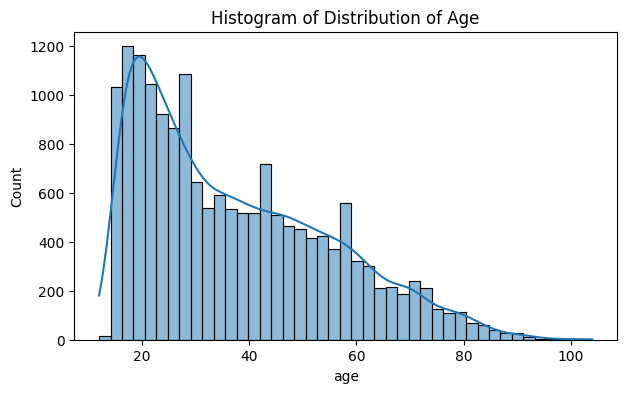

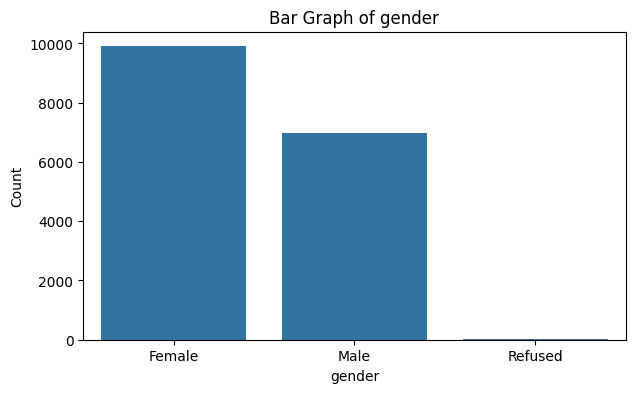

In [6]:
# Temporary dataframe used to mainting indexing when deriving new columns
temp_df = pd.DataFrame({})

'''
AGE (Derived) : Integer

Provides the age of the participant at the time of the interview.
'''
# Calculated age by taking interview year minus year of birth
years: pd.Series = df['birth_year'].replace('Missing', pd.NA).replace("Don't know", pd.NA).replace("Refused", pd.NA).dropna()
# years = years.fillna(years.mode()[0])
df['age'] = df[f'w{wave_num}_a_intrv_y'] - years.astype(float)
new_df['age'] = df['age'].astype('Int32')

if PLOT: plotter.plot_histogram(new_df['age'], "Distribution of Age")

print(new_df.count())

'''
GENDER : Integer (Class)

Factorizes gender.
'''
temp_df['gender'], getGender = pd.factorize(df['gender'])
# print("GENDER:", getGender,"\n", temp_df['gender'].unique())

# fig, axs = plt.subplots(1, 2, figsize=(14, 4))
if PLOT: plotter.plot_bar(df['gender'], title="gender", log_scale=False)

new_df['gender'] = temp_df['gender'].fillna(temp_df['gender'].mode()[0])

# # Check which rows have NaN values
# nan_rows = new_df[new_df.isna().any(axis=1)]

# # Print rows with NaN values
# print(nan_rows)

RACE: Index(['African', 'Asian/Indian', 'White', 'Coloured', 'Refused',
       'Other (specify)', 'Other'],
      dtype='object') 
 [0 1 2 3 4 5 6]
MARITAL_STATUS: Index(['Widow/Widower', 'Married', 'Never married', 'Divorced or separated',
       'Living with partner', 'Don't know', 'Refused', 'Missing'],
      dtype='object') 
 [0 1 2 3 4 5 6 7]
BORN_PROVINCE: Index(['Missing', 'Eastern Cape', 'KwaZulu-Natal', 'Gauteng', 'Limpopo',
       'Outside RSA', 'Mpumalanga', 'North West', 'Free State',
       'Northern Cape', 'Western Cape', 'Refused', 'Don't Know'],
      dtype='object') 
 ['Missing' 'Eastern Cape' 'KwaZulu-Natal' 'Gauteng' 'Limpopo'
 'Outside RSA' 'Mpumalanga' 'North West' 'Free State' 'Northern Cape'
 'Western Cape' 'Refused' "Don't Know"]


pid               16900
age               16889
gender            15114
race              15114
marital_status    15114
born_province     15114
dtype: int64
pid               16900
age               16889
gender            15114
race              15114
marital_status    15114
born_province     15114
dtype: int64


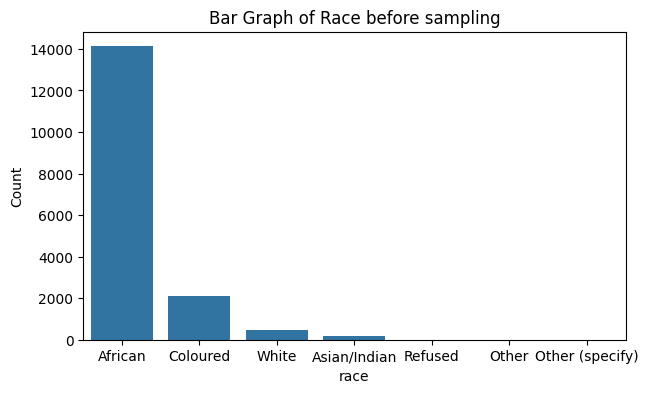

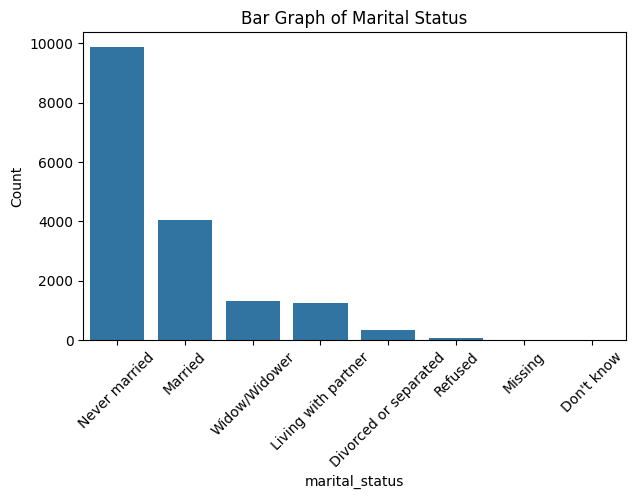

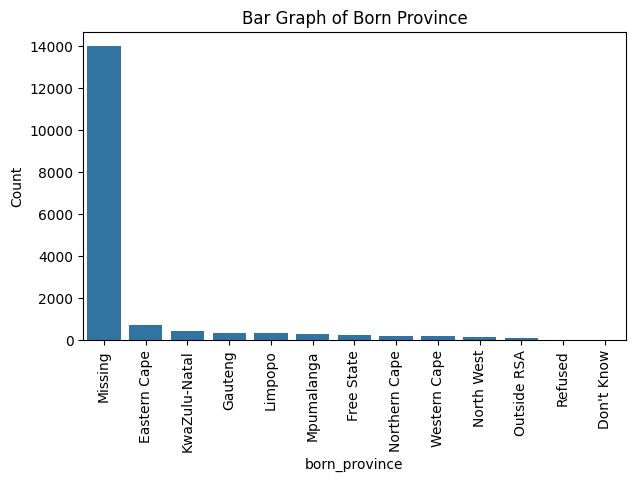

In [7]:
'''
RACE : Integer (Class)

Any nan or missing entries were replaced with the class "Other". This helps retain as much info as possible.
'''
# Combined Nan and Missing entries together as their own class and factorized
df['race'] = df['race'].replace(pd.NA, 'Other').replace('Missing', 'Other')
temp_df['race'], getRace = pd.factorize(df['race'])
print("RACE:", getRace,"\n", temp_df['race'].unique())

if PLOT: plotter.plot_bar(df['race'], title="Race before sampling", log_scale=False)

new_df['race'] = temp_df['race']

'''
MARITAL_STATUS : Integer (Class)

Includes missing as an option/value.
'''
temp_df['marital_status'], getMaritalStatus = pd.factorize(df['marital_status'])
print("MARITAL_STATUS:", getMaritalStatus,"\n", temp_df['marital_status'].unique())

if PLOT: plotter.plot_bar(df['marital_status'], title="Marital Status", log_scale=False, rotation=45)

new_df['marital_status'] = temp_df['marital_status']

'''
BORN_PROVINCE : Integer (Class)

Replaced Nan values with Missing. Importantly, about half of wave 1 seem to 
'''

df['born_province'] = df['born_province'].replace(pd.NA, "Missing")
# df['born_province'] = df['born_province'].dropna()
temp_df['born_province'], getBornProvince = pd.factorize(df['born_province'])
print("BORN_PROVINCE:", getBornProvince,"\n", df['born_province'].unique())

if PLOT: plotter.plot_bar(df['born_province'], title="Born Province", log_scale=False, rotation=90)

new_df['born_province'] = temp_df['born_province']

print(new_df.count())

new_df = new_df.fillna(new_df.mode())

print(new_df.count())

### Section C1: Children ever born (Only for Females)

### Section D: Parents’ education, living arrangements and vital status

### Section E: Labour market participation

Also includes Section F1: Individual income from non-employment sources

EMPLOYED: Index(['No', 'Yes', 'Refused', 'Don't know'], dtype='object') 
 [0 1 2 3]


SELF_EMPLOYED: Index(['No', 'Yes', 'Refused', 'Don't know'], dtype='object') 
 [0 1 2 3]


CASUAL_WORK: Index(['No', 'Yes', 'Refused', 'Don't know'], dtype='object') 
 [0 1 2 3]


'\nEXTRA_INCOME (Derived) : Float\n\nThere are a list of columns relating to extra incomes received from various sources. These include government grants, gifts, dontations etc.\n\nEach column will be summed to form a new column that represents the total income gained from extra sources, other than employment.\n'

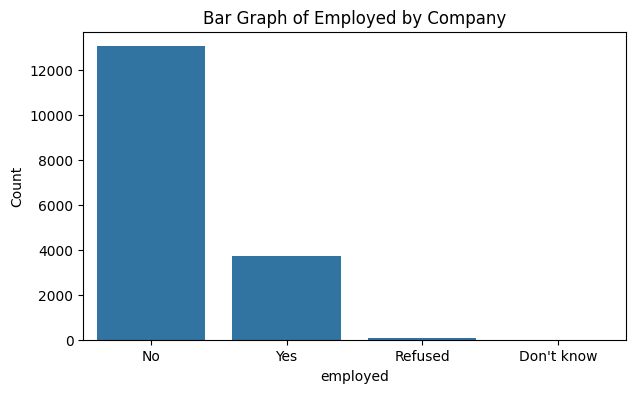

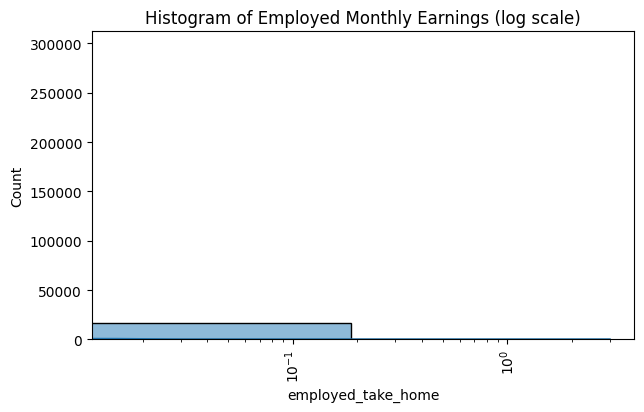

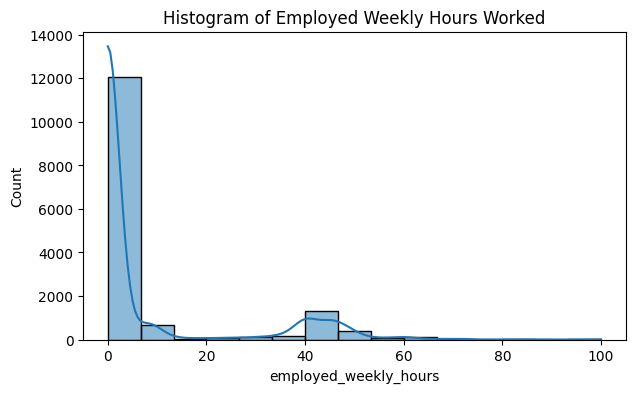

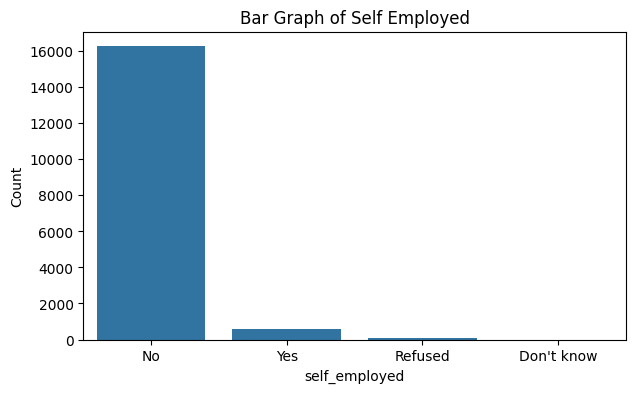

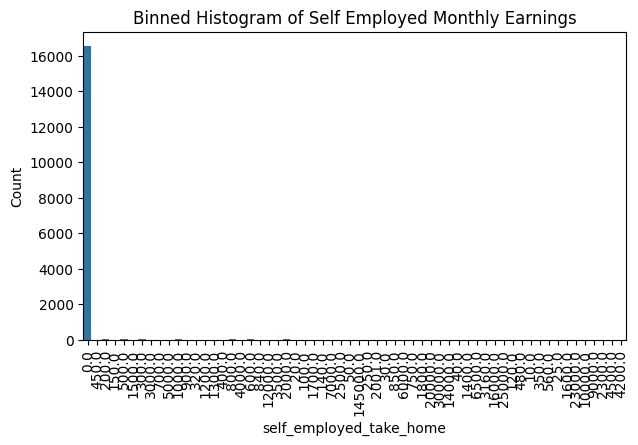

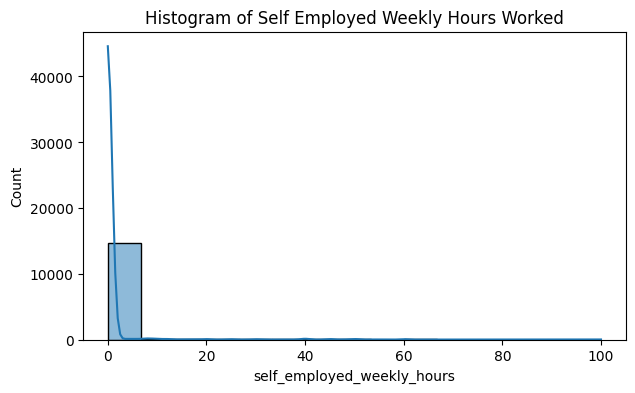

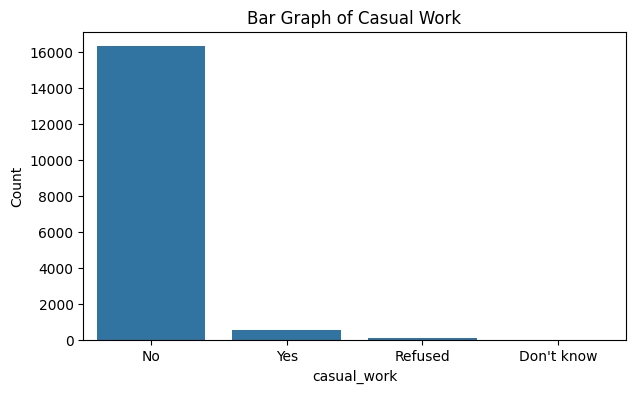

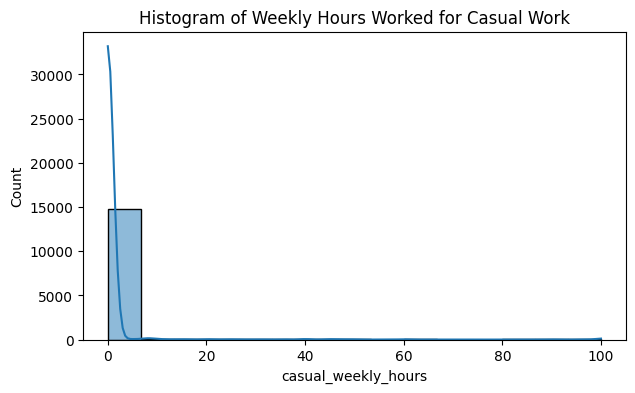

In [8]:
'''
EMPLOYED : Integer (Class)

1 or 0 if participant is employed at some company. Missing replaced with Refused since both indicate similar decisions
'''
df['employed'] = df['employed'].replace('Missing', 'Refused')
temp_df['employed'], getEmployedBool = pd.factorize(df['employed'])
print("EMPLOYED:", getEmployedBool,"\n", temp_df['employed'].unique())

if PLOT: plotter.plot_bar(df['employed'], title="Employed by Company", log_scale=False, rotation=0)

new_df['employed'] = temp_df['employed']

'''
EMPLOYED_TAKE_HOME : FLOAT -> Integer (Class)

Replaced any item that was a string or NA with 0. The amounts are discretized into bins.
'''
df['employed_take_home'] = df['employed_take_home'].replace('Missing', 0.0).replace("Refused", 0.0).replace("Don't know", 0.0).replace(pd.NA, 0.0).replace("Not Applicable", 0.0)

temp_df['employed_take_home'], getEmployedTakeHome = pd.factorize(pd.cut(pd.to_numeric(df['employed_take_home']), bins=30))

if PLOT: plotter.plot_histogram(temp_df['employed_take_home'], title="Employed Monthly Earnings", log_scale=True, rotation=90)

new_df['employed_take_home'] = temp_df['employed_take_home']

'''
EMPLOYED_WEEKLY_HOURS : Integer

Replaced any item that was a string or NA with 0. I haven't binned this feature since Hours worked weekly will have frequent hour amounts.
'''
df['employed_weekly_hours'] = df['employed_weekly_hours'].replace('Missing', 0).replace("Refused", 0).replace("Don't know", 0).replace(pd.NA, 0).replace("Not Applicable", 0)
df['employed_weekly_hours'] =  pd.to_numeric(df['employed_weekly_hours']).astype('Int32')

# CAPPED ENTRIES WHERE EMPLOYED WEEKLY HOURS IS GREATER THAN 100
# IF A PARTICIPANT HAS MORE THAN 100 HOURS WORKED, THIS GETS CLIPPED DOWN TO 100
temp_df['employed_weekly_hours'] = df['employed_weekly_hours'].clip(upper=100)

if PLOT: plotter.plot_histogram(temp_df['employed_weekly_hours'], title="Employed Weekly Hours Worked", log_scale=False, rotation=0)

new_df['employed_weekly_hours'] = temp_df['employed_weekly_hours'] 


'''
SELF_EMPLOYED : Integer (Class)

1 or 0 if participant is self employed. Missing replaced with Refused since both indicate similar decisions
'''
df['self_employed'] = df['self_employed'].replace('Missing', 'Refused')
temp_df['self_employed'], getSelfEmployedBool = pd.factorize(df['self_employed'])
print("SELF_EMPLOYED:", getSelfEmployedBool,"\n", temp_df['self_employed'].unique())

if PLOT: plotter.plot_bar(df['self_employed'], title="Self Employed", log_scale=False, rotation=0)

new_df['self_employed'] = temp_df['self_employed']

'''
SELF_EMPLOYED_TAKE_HOME : FLOAT -> Integer (Class)

Replaced any item that was a string or NA with 0. The amounts are discretized into bins.
'''
df['self_employed_take_home'] = df['self_employed_take_home'].replace('Missing', 0.0).replace("Refused", 0.0).replace("Don't know", 0.0).replace(pd.NA, 0.0).replace("Not Applicable", 0.0)

temp_df['self_employed_take_home'], getSelfEmployedTakeHome = pd.factorize(pd.cut(pd.to_numeric(df['self_employed_take_home']), bins=30))

if PLOT: plotter.plot_histogram(df['self_employed_take_home'], title="Self Employed Monthly Earnings", log_scale=True, rotation=90)

new_df['self_employed_take_home'] = temp_df['self_employed_take_home']

'''
EMPLOYED_WEEKLY_HOURS : Integer

Replaced any item that was a string or NA with 0. I haven't binned this feature since Hours worked weekly will have frequent hour amounts.
'''
df['self_employed_weekly_hours'] = df['self_employed_weekly_hours'].replace('Missing', 0).replace("Refused", 0).replace("Don't know", 0).replace(pd.NA, 0).replace("Not Applicable", 0)
df['self_employed_weekly_hours'] =  pd.to_numeric(df['self_employed_weekly_hours']).astype('Int32')

# CAPPED ENTRIES WHERE EMPLOYED WEEKLY HOURS IS GREATER THAN 100
# IF A PARTICIPANT HAS MORE THAN 100 HOURS WORKED, THIS GETS CLIPPED DOWN TO 100
temp_df['self_employed_weekly_hours'] = df['self_employed_weekly_hours'].clip(upper=100)

if PLOT: plotter.plot_histogram(temp_df['self_employed_weekly_hours'], title="Self Employed Weekly Hours Worked", log_scale=False, rotation=0)

new_df['self_employed_weekly_hours'] = temp_df['self_employed_weekly_hours'] 

'''
CASUAL_WORK : Integer (Class)

1 or 0 if participant is does casual work, eg. Farming, Vendoring. Missing replaced with Refused since both indicate similar decisions
'''
df['casual_work'] = df['casual_work'].replace('Missing', 'Refused')
temp_df['casual_work'], getCasualWorkBool = pd.factorize(df['casual_work'])
print("CASUAL_WORK:", getCasualWorkBool,"\n", temp_df['casual_work'].unique())

if PLOT: plotter.plot_bar(df['casual_work'], title="Casual Work", log_scale=False, rotation=0)

new_df['casual_work'] = temp_df['casual_work']

'''
CASUAL_WEEKLY_HOURS : Integer

Replaced any item that was a string or NA with 0. I haven't binned this feature since Hours worked weekly will have frequent hour amounts.
'''
df['casual_weekly_hours'] = df['casual_weekly_hours'].replace('Missing', 0).replace("Refused", 0).replace("Don't know", 0).replace(pd.NA, 0).replace("Not Applicable", 0)
df['casual_weekly_hours'] =  pd.to_numeric(df['casual_weekly_hours']).astype('Int32')

# CAPPED ENTRIES WHERE EMPLOYED WEEKLY HOURS IS GREATER THAN 100
# IF A PARTICIPANT HAS MORE THAN 100 HOURS WORKED, THIS GETS CLIPPED DOWN TO 100
temp_df['casual_weekly_hours'] = df['casual_weekly_hours'].clip(upper=100)

if PLOT: plotter.plot_histogram(temp_df['casual_weekly_hours'], title="Weekly Hours Worked for Casual Work", log_scale=False, rotation=0)

new_df['casual_weekly_hours'] = temp_df['casual_weekly_hours'] 

'''
EXTRA_INCOME (Derived) : Float

There are a list of columns relating to extra incomes received from various sources. These include government grants, gifts, dontations etc.

Each column will be summed to form a new column that represents the total income gained from extra sources, other than employment.
'''
# # Firstly replacing entries which aren't numbers with 0
# for income_type in other_incomes:
#     df[income_type] = df[income_type].replace('Missing', 0.0).replace("Refused", 0.0).replace("Don't know", 0.0).replace(pd.NA, 0.0).replace("Not Applicable", 0.0)
#     df[income_type] = pd.to_numeric(df[income_type])
#     print(df[income_type].unique())

# temp_df['extra_income'] = df[other_incomes[0]]
# for i in range(1, len(other_incomes)):
#     temp_df['extra_income'] += df[other_incomes[i]]

# if PLOT: plotter.plot_histogram(temp_df['extra_income'], title="Extra income gained from sources other than employment", log_scale=True, rotation=90)

# new_df['extra_income'] = pd.factorize(pd.cut(pd.to_numeric(temp_df['extra_income']), bins=30))

# print(temp_df['extra_income'].head(10))


### Section G: Personal ownership and debt

### Section H: Education

HIGHEST_GRADE_SCHOOL: Index(['No schooling', 'Grade 5/Std. 3', 'Grade 8/Std. 6/Form 1',
       'Grade 3/Std. 1', 'Grade 9/Std. 7/Form 2', 'Grade 1/Sub A/Class 1',
       'Grade 7/Std. 5', 'Grade 4/Std. 2', 'Grade 6/Std. 4',
       'Grade 11/Std. 9/Form 4',
       'Grade 12/Std. 10/Form 5/Matric/Senior Certificate',
       'Grade 10/Std. 8/Form 3', 'Grade 2/Sub B/Class 2', 'Other (specify)',
       'NTC 2', 'Refused', 'Missing', 'Don't know', 'NTC 1', 'NTC 3',
       'Grade R/0'],
      dtype='object') 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
TERTIARY_EDUCATION: Index(['Missing', 'No', 'Yes', 'Refused', 'Don't know'], dtype='object') 
 [0 1 2 3 4]
CURRENTLY_ENROLLED: Index(['Missing', 'No', 'Yes', 'Refused', 'Don't know'], dtype='object') 
 [0 1 2 3 4]


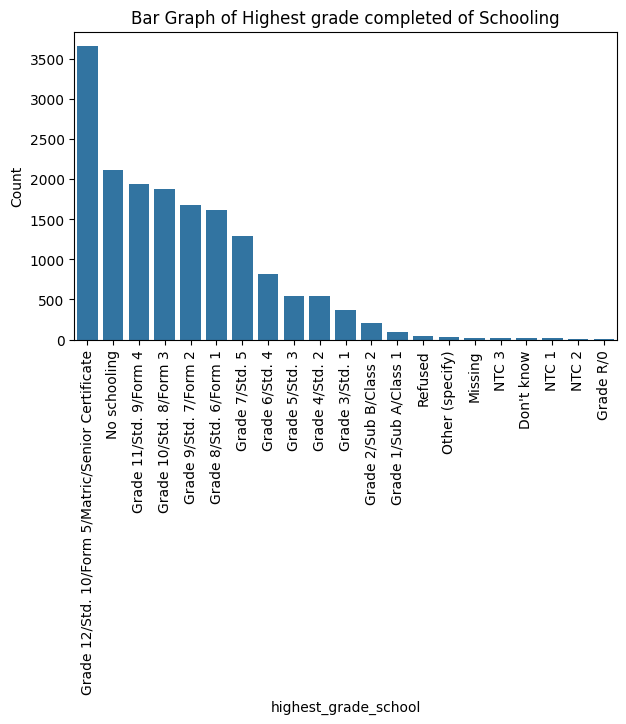

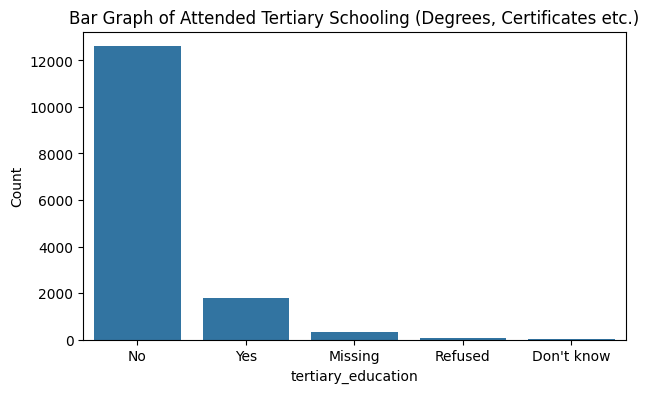

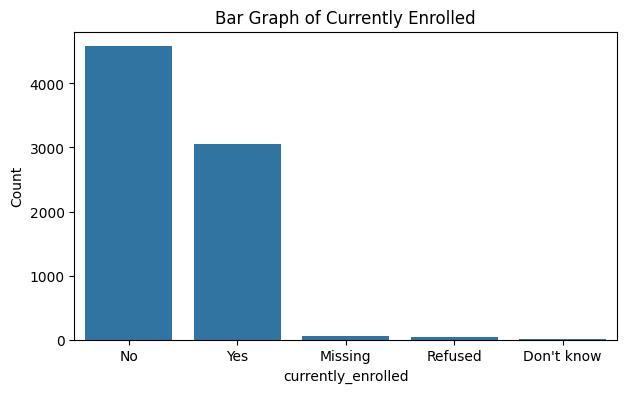

In [9]:
'''
HIGHEST_GRADE_SCHOOL : Integer (Class)

Includes missing, refused, not applicable and don't know as options/values.
'''
temp_df['highest_grade_school'], getHighestGradeSchool = pd.factorize(df['highest_grade_school'])
print("HIGHEST_GRADE_SCHOOL:", getHighestGradeSchool,"\n", temp_df['highest_grade_school'].unique())

if PLOT: plotter.plot_bar(df['highest_grade_school'], title="Highest grade completed of Schooling", log_scale=False, rotation=90)

new_df['highest_grade_school'] = temp_df['highest_grade_school']

'''
TERTIARY_EDUCATION : Integer (Class)

Whether the participant completed some form of Tertiary Education (Degrees, Certificates etc.)

Includes missing, refused, and don't know as options/values.
'''
temp_df['tertiary_education'], getTertiaryEducation = pd.factorize(df['tertiary_education'].replace(pd.NA, 'Missing'))
print("TERTIARY_EDUCATION:", getTertiaryEducation,"\n", temp_df['tertiary_education'].unique())

if PLOT: plotter.plot_bar(df['tertiary_education'], title="Attended Tertiary Schooling (Degrees, Certificates etc.)", log_scale=False, rotation=0)

new_df['tertiary_education'] = temp_df['tertiary_education']

'''
CURRENTLY_ENROLLED : Integer (Class)

Whether the participant is enrolled in some form of Schooling or Education this year.

Includes missing as an option/value.
'''
temp_df['currently_enrolled'], getCurrentlyEnrolled = pd.factorize(df['currently_enrolled'].replace(pd.NA, 'Missing'))
print("CURRENTLY_ENROLLED:", getCurrentlyEnrolled,"\n", temp_df['currently_enrolled'].unique())

if PLOT: plotter.plot_bar(df['currently_enrolled'], title="Currently Enrolled", log_scale=False, rotation=0)

new_df['currently_enrolled'] = temp_df['currently_enrolled']

# '''
# ATTENDED_COURSES : Integer (Class)

# Whether the participant attended university/school courses in the prior year.

# Includes missing, refused, and don't know as options/values.
# '''
# temp_df['attended_courses'], getAttendedCourses = pd.factorize(df['attended_courses'].replace(pd.NA, 'Missing'))
# print("ATTENDED_COURSES:", getAttendedCourses,"\n", temp_df['attended_courses'].unique())

# if PLOT: plotter.plot_bar(df['attended_courses'], title="Attended Courses Last Year (Degrees, Certificates etc.)", log_scale=False, rotation=0)

# new_df['attended_courses'] = temp_df['attended_courses']



### Section J: Health

HEALTH_STATUS: Index(['Fair', 'Excellent', 'Good', 'Very good', 'Poor', 'Don't know',
       'Refused', 'Missing'],
      dtype='object') 
 [0 1 2 3 4 5 6 7]
SUMMARY STATISTICS FOR VARIOUS HEALTH CONDITIONS
        flu_symptoms         fever  persistent_cough  cough_with_blood  \
count  16900.000000  16900.000000      16900.000000      16900.000000   
mean       0.207633      0.143373          0.909231          0.026450   
std        0.443934      0.394021          0.340455          0.243402   
min        0.000000      0.000000          0.000000          0.000000   
25%        0.000000      0.000000          1.000000          0.000000   
50%        0.000000      0.000000          1.000000          0.000000   
75%        0.000000      0.000000          1.000000          0.000000   
max        5.000000      5.000000          5.000000          5.000000   

        tight_chest    chest_pain     body_ache      headache     back_ache  \
count  16900.000000  16900.000000  16900.000000  16900.

MEDICINE_PRESCRIBED_AT_PREV_CONSULTATION: Index(['Consultation Too Distant', 'No', 'Yes', 'Don't know', 'Refused',
       'Missing'],
      dtype='object') 
 [0 1 2 3 4 5]
<IntegerArray>
[  -1,    7,    1,    4,    2,    6,    5,    3,   11,   10,    8,   13,   21,
    0,   36,   26,   17,   16,   25,   40,   33,   19,   22,    9,   32,   12,
   30,   50,   27,   20,   18,   47,   14,   38,   43,   15,   28,   48,   41,
   35, <NA>]
Length: 41, dtype: Int32 15114
<IntegerArray>
[  -1,    7,    0,    2,   20,    3,    9,    1,    5,    4,   10,    6,   11,
   18,   30,    8,   12,   16,   39,   40,   14,   44,   23,   37,   36,   42,
   15,   17,   51,   24,   25,   26,   21,   28,   22,   13,   31,   29,   19,
   32,   27,   41,   50,   34,   35,   33,   52, <NA>]
Length: 48, dtype: Int32 15114
<IntegerArray>
[  -1,    1,    0,    8,    5,    4,   19,   34,    6,   11,    3,   20,    9,
   25,   32,   16,    2,    7,   37,   14,   17,   24,   13,   10,   30,   31,
   12,   21,   18,   

SMOKES_CIGARETTES: Index(['No', 'Yes', 'Refused', 'Don't know', 'Missing'], dtype='object') 
 [0 1 2 3 4]
ALCOHOL_FREQUENCY: Index(['I have never drank alcohol', 'I drink very rarely',
       'I no longer drink alcohol', 'Less than once a week',
       'On 3 or 4 days a week', 'On 1 or 2 days a week',
       'On 5 or 6 days a week', 'Every day', 'Don't know', 'Refused',
       'Missing'],
      dtype='object') 
 [ 0  1  2  3  4  5  6  7  8  9 10]
ALCOHOL_QUANTITY: Index(['3 or 4 standard drinks', '5 to 6 standard drinks',
       '7 to 8 standard drinks', '1 or 2 standard drinks',
       '13 or more standard drinks', '9 to 12 standard drinks', 'Don't know',
       'Missing', 'Refused'],
      dtype='object') 
 [-1  0  1  2  3  4  5  6  7  8]


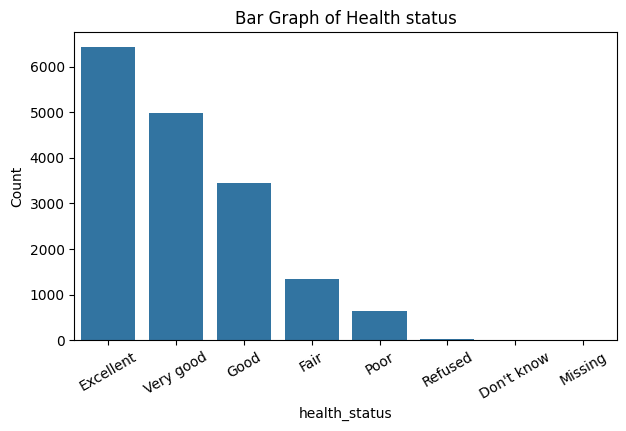

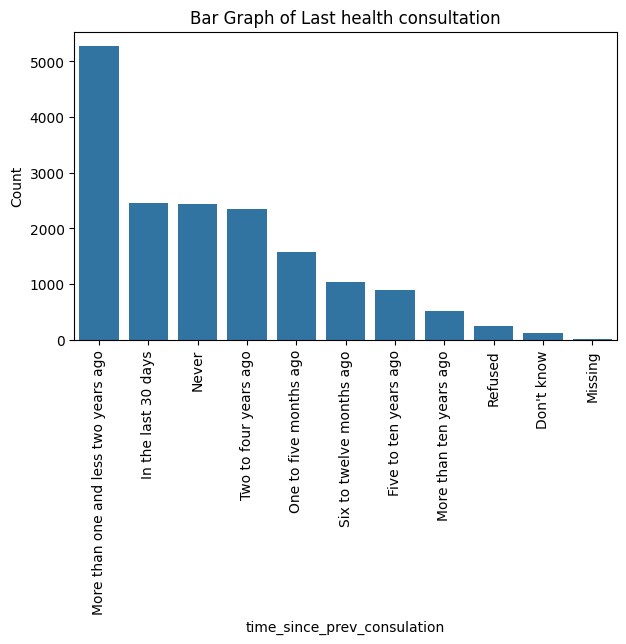

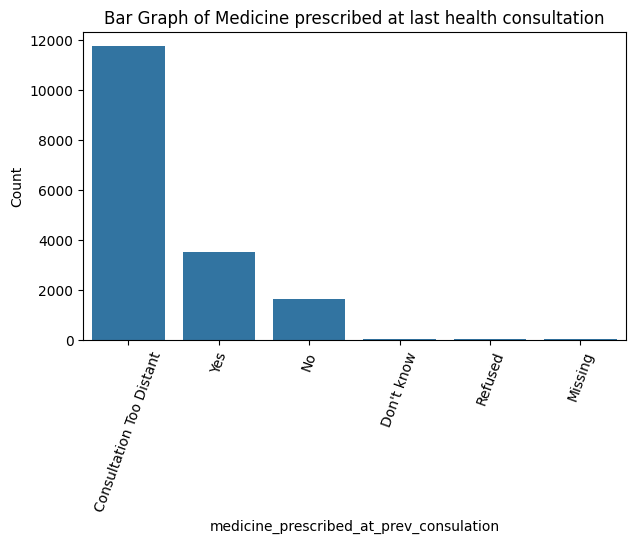

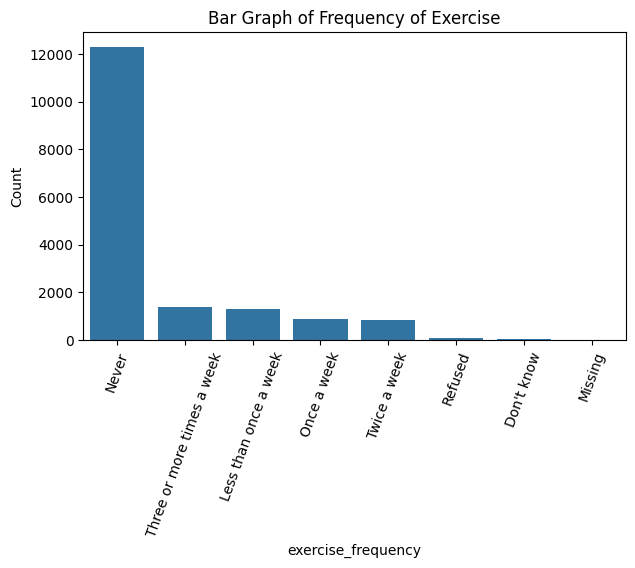

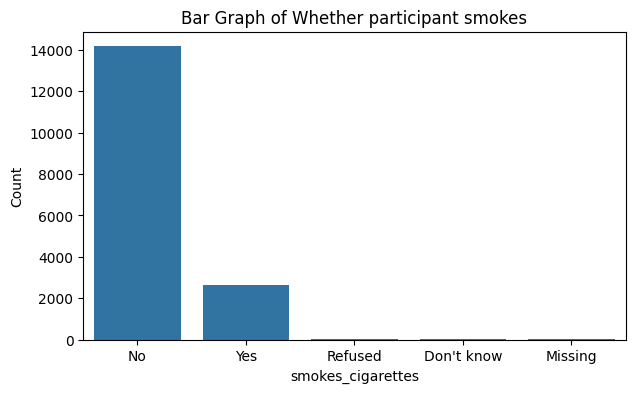

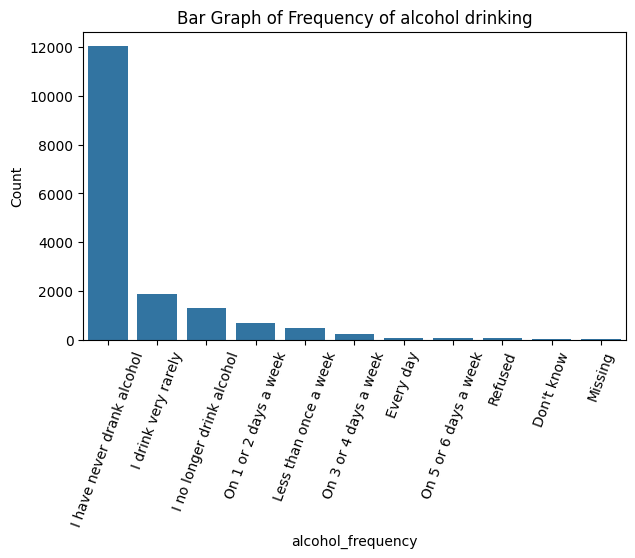

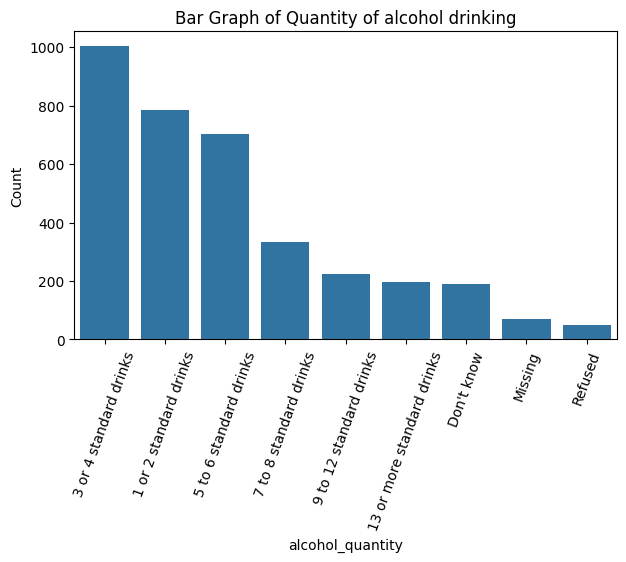

In [10]:
'''
HEALTH_STATUS : Integer (Class)

Ranges from 1-5. Self-description of current health, 1 being excellent, 5 being poor

Decided to include missing, don't know and refused as options since they might reveal correlations.
'''
temp_df['health_status'], getHealthStatus = pd.factorize(df['health_status'])
print("HEALTH_STATUS:", getHealthStatus,"\n", temp_df['health_status'].unique())

if PLOT: plotter.plot_bar(df['health_status'], title="Health status", log_scale=False, rotation=30)

'''
The following section is a list of health condition features. The participant was asked to say yes to any of the following conditions if they experienced them in the past 30 days.
'''

conditions = [
    "flu_symptoms",
    "fever",
    "persistent_cough",
    "cough_with_blood",
    "tight_chest",
    "chest_pain",
    "body_ache",
    "headache",
    "back_ache",
    "joint_pain_arthritis",
    "vomiting",
    "diarrhoea",
    "felt_weak",
    "pain_in_upper_abdomen",
    "pain_in_lower_abdomen",
    "painful_urination",
    "swelling_ankles",
    "rash",
    "skin_disorders",
    "conjunctivitis_eye_infection",
    "severe_weight_loss",
    "yellow_eyes",
    "memory_loss",
    "serious_injury"
]

getConditions = []

for condition in conditions:
    new_df[condition], getCondition = pd.factorize(df[condition].replace('Not Applicable', 'Missing'))
    getConditions.append(getCondition)

# Generate summary statistics for all condition columns
summary_stats = new_df[conditions].describe()

# Print the summary stats
print("SUMMARY STATISTICS FOR VARIOUS HEALTH CONDITIONS\n", summary_stats)

'''
TIME_SINCE_PREV_CONSULTATION : Integer (Class)

Options range from 1 (In the last 30 days) to 8 (Never)
'''
if wave_num == 2: df['time_since_prev_consulation'] = df['time_since_prev_consulation'].replace("Not asked in Phase 2", "Don't know")

temp_df['time_since_prev_consulation'], getTimeSincePrevConsulation = pd.factorize(df['time_since_prev_consulation'].replace("Not asked in Phase 2", "Don't know"))
print("TIME_SINCE_PREV_CONSULTATION:", getTimeSincePrevConsulation,"\n", temp_df['time_since_prev_consulation'].unique())

if PLOT: plotter.plot_bar(df['time_since_prev_consulation'], title="Last health consultation", log_scale=False, rotation=90)

new_df['time_since_prev_consulation'] = temp_df['time_since_prev_consulation']

'''
MEDICINE_PRESCRIBED_AT_PREV_CONSULTATION: Integer (Class)

If this feature is Nan, it indicates that the participants previous consultation was more than one and less two years ago, according to the questionnaire.
Thus I created a new value "Consultation Too Distant" for these entries.
'''
df['medicine_prescribed_at_prev_consulation'] = df['medicine_prescribed_at_prev_consulation'].replace(pd.NA, "Consultation Too Distant")
temp_df['medicine_prescribed_at_prev_consulation'], getMedicinePrescribedAtPrevConsulation = pd.factorize(df['medicine_prescribed_at_prev_consulation'])
print("MEDICINE_PRESCRIBED_AT_PREV_CONSULTATION:", getMedicinePrescribedAtPrevConsulation,"\n", temp_df['medicine_prescribed_at_prev_consulation'].unique())

if PLOT: plotter.plot_bar(df['medicine_prescribed_at_prev_consulation'], title="Medicine prescribed at last health consultation", log_scale=False, rotation=70)

new_df['medicine_prescribed_at_prev_consulation'] = temp_df['medicine_prescribed_at_prev_consulation']


'''
The following section is a list of persistent/long-term health conditions.

Each condition is a separate feature, with an associated feature for the number of years since the diagnosis (at the time of the interview).
'''

temp_df['had_tubercolosis'], getHadTB = pd.factorize(df['had_tubercolosis'].replace({'No': 0, "Yes": 1}))
temp_df['had_high_blood_pressure'], getHadTB = pd.factorize(df['had_high_blood_pressure'].replace({'No': 0, "Yes": 1}))
temp_df['had_diabetes_or_high_blood_sugar'], getHadTB = pd.factorize(df['had_diabetes_or_high_blood_sugar'].replace({'No': 0, "Yes": 1}))
temp_df['had_stroke'], getHadTB = pd.factorize(df['had_stroke'].replace({'No': 0, "Yes": 1}))
temp_df['had_asthma'], getHadTB = pd.factorize(df['had_asthma'].replace({'No': 0, "Yes": 1}))
temp_df['had_heart_problems'], getHadTB = pd.factorize(df['had_heart_problems'].replace({'No': 0, "Yes": 1}))
temp_df['had_cancer'], getHadTB = pd.factorize(df['had_cancer'].replace({'No': 0, "Yes": 1}))

persistent_conditions = ['tb', 'hbp', 'dia', 'strk', 'ast', 'hrt', 'can']
mapping = {'tb': 'tubercolosis', 'hbp': 'high_blood_pressure', 'dia': 'diabetes_or_high_blood_sugar', 'strk': 'stroke', 'ast': 'asthma', 'hrt': 'heart_problems', 'can': 'cancer'}

for con in persistent_conditions:
    # Replace invalid entries in tb_diagnosis_year with -200 as a flag
    years = df[f'{con}_diagnosis_year'].replace(['Missing', "Don't know", 'Refused', pd.NA], -200).dropna().astype(float)

    # Calculate diagnosis age for those who had tuberculosis
    temp_df[f'{con}_diagnosis_age'] = df[f'w{wave_num}_a_intrv_y'] - years

    # Identify entries where the above flag is true
    temp_df[f'w{wave_num}_a_intrv_y'] = df[f'w{wave_num}_a_intrv_y']
    condition = (temp_df[f'{con}_diagnosis_age'] == temp_df[f'w{wave_num}_a_intrv_y'] + 200)

    # Set those diagnosis age entries to -1
    temp_df.loc[condition, f'{con}_diagnosis_age'] = -1

    mapped_condition = mapping[con]
    # Set diagnosis age to -1 if 'had_tuberculosis' is not 1
    temp_df[f'{con}_diagnosis_age'] = temp_df[f'{con}_diagnosis_age'].where(df[f'had_{mapped_condition}'] != 1, -1)

    # Convert to Int32 (to allow for -1 and NaN values)
    new_df[f'{con}_diagnosis_age'] = temp_df[f'{con}_diagnosis_age'].astype('Int32')

    print(new_df[f'{con}_diagnosis_age'].unique(), new_df[f'{con}_diagnosis_age'].count())

'''
EXERCISE_FREQUENCY : Integer (Class)

Options are:
Never
Less than once a week
Once a week
Twice a week
Three or more times a week
'''
if wave_num == 2: df['exercise_frequency'] = df['exercise_frequency'].replace("Not asked in Phase 2", "Don't know")

temp_df['exercise_frequency'], getExerciseFrequency = pd.factorize(df['exercise_frequency'].replace("Not asked in Phase 2", "Don't know"))
print("EXERCISE_FREQUENCY:", getExerciseFrequency,"\n", temp_df['exercise_frequency'].unique())

if PLOT: plotter.plot_bar(df['exercise_frequency'], title="Frequency of Exercise", log_scale=False, rotation=70)

new_df['exercise_frequency'] = temp_df['exercise_frequency']

'''
SMOKES_CIGARETTES : Integer (Class)

Yes or no.
'''
if wave_num == 2: df['smokes_cigarettes'] = df['smokes_cigarettes'].replace("Not asked in Phase 2", "Don't know")

df['smokes_cigarettes'] = df['smokes_cigarettes'].replace({pd.NA: 'Missing', 'Not Applicable': 'Missing'}).replace("Not asked in Phase 2", "Don't know")
temp_df['smokes_cigarettes'], getSmoker = pd.factorize(df['smokes_cigarettes'])
print("SMOKES_CIGARETTES:", getSmoker,"\n", temp_df['smokes_cigarettes'].unique())

if PLOT: plotter.plot_bar(df['smokes_cigarettes'], title="Whether participant smokes", log_scale=False, rotation=0)

new_df['smokes_cigarettes'] = temp_df['smokes_cigarettes']

'''
ALCOHOL_FREQUENCY : Integer (Class)

Options are:
I have never drunk alcohol→ SKIP TO J33 1
I no longer drink alcohol→ SKIP TO J33 2
I drink very rarely 3
Less than once a week 4
On 1 or 2 days a week 5
On 3 or 4 days a week 6
On 5 or 6 days a week 7
Every day 8
'''
if wave_num == 2: df['alcohol_frequency'] = df['alcohol_frequency'].replace("Not asked in Phase 2", "Don't know")

temp_df['alcohol_frequency'], getAlcoholFrequency = pd.factorize(df['alcohol_frequency'].replace("Not asked in Phase 2", "Don't know"))
print("ALCOHOL_FREQUENCY:", getAlcoholFrequency,"\n", temp_df['alcohol_frequency'].unique())

if PLOT: plotter.plot_bar(df['alcohol_frequency'], title="Frequency of alcohol drinking", log_scale=False, rotation=70)

new_df['alcohol_frequency'] = temp_df['alcohol_frequency']

'''
ALCOHOL_QUANTITY : Integer (Class)

Options are:
13 or more standard drinks 1
9 to 12 standard drinks 2
7 to 8 standard drinks 3
5 to 6 standard drinks 4
3 or 4 standard drinks 5
1 or 2 standard drinks 6
'''
if wave_num == 2: df['alcohol_quantity'] = df['alcohol_quantity'].replace("Not asked in Phase 2", "Don't know")

temp_df['alcohol_quantity'], getAlcoholQuantity = pd.factorize(df['alcohol_quantity'])
print("ALCOHOL_QUANTITY:", getAlcoholQuantity,"\n", temp_df['alcohol_quantity'].unique())

if PLOT: plotter.plot_bar(df['alcohol_quantity'], title="Quantity of alcohol drinking", log_scale=False, rotation=70)

new_df['alcohol_quantity'] = temp_df['alcohol_quantity']


### Section N: Measurements

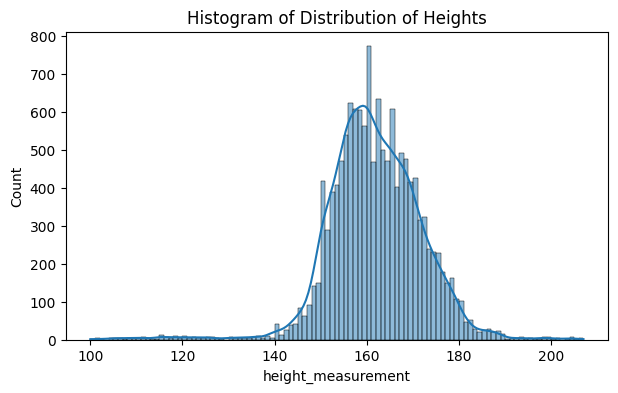

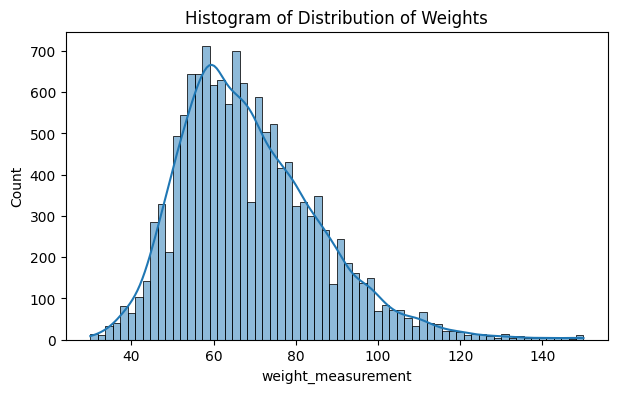

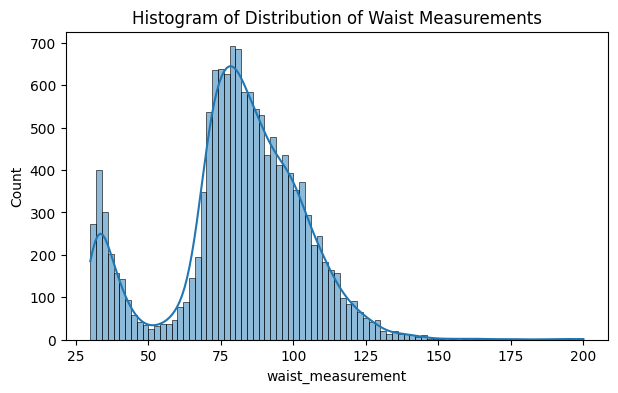

In [11]:
# f'w{wave_num}_a_height_1'
# f'w{wave_num}_a_weight_1'
# f'w{wave_num}_a_waist_1'

'''
The following columns all relate to measurements done during the interview of each participant.

These include: Height, Weight, Waist

Each column is cut/binned to create new discrete columns.
'''

# Replace NaN values with the mean of the column

# print(df['height_measurement'].replace({'Missing': pd.NA, 'Refused': pd.NA, 'Not Applicable': pd.NA, "Don't know": pd.NA}).dropna().count())
# height_ave = df['height_measurement'].replace({'Missing': pd.NA, 'Refused': pd.NA, 'Not Applicable': pd.NA, "Don't know": pd.NA}).dropna().astype(float).mean()
# weight_ave = df['weight_measurement'].replace({'Missing': pd.NA, 'Refused': pd.NA, 'Not Applicable': pd.NA, "Don't know": pd.NA}).dropna().astype(float).mean()
# waist_ave = df['waist_measurement'].replace({'Missing': pd.NA, 'Refused': pd.NA, 'Not Applicable': pd.NA, "Don't know": pd.NA}).dropna().astype(float).mean()

if wave_num == 2:
    df['height_measurement'] = df['height_measurement'].replace('Not asked in Phase 2', pd.NA)
    df['weight_measurement'] = df['weight_measurement'].replace('Not asked in Phase 2', pd.NA)
    df['waist_measurement'] = df['waist_measurement'].replace('Not asked in Phase 2', pd.NA)

height_diff = df['height_measurement'].count()
weight_diff = df['weight_measurement'].count()
waist_diff = df['waist_measurement'].count()

temp_df['height_measurement'] = df['height_measurement'].replace({'Missing': pd.NA, 'Refused': pd.NA, 'Not Applicable': pd.NA, "Don't know": pd.NA}).dropna().astype(float)
temp_df['weight_measurement'] = df['weight_measurement'].replace({'Missing': pd.NA, 'Refused': pd.NA, 'Not Applicable': pd.NA, "Don't know": pd.NA}).dropna().astype(float)
temp_df['waist_measurement'] = df['waist_measurement'].replace({'Missing': pd.NA, 'Refused': pd.NA, 'Not Applicable': pd.NA, "Don't know": pd.NA}).dropna().astype(float)

if PLOT: plotter.plot_histogram(temp_df['height_measurement'], "Distribution of Heights")
if PLOT: plotter.plot_histogram(temp_df['weight_measurement'], "Distribution of Weights")
if PLOT: plotter.plot_histogram(temp_df['waist_measurement'], "Distribution of Waist Measurements")

new_df['height_measurement'] = pd.cut(temp_df['height_measurement'], bins=100).astype('category').cat.codes
new_df['weight_measurement'] = pd.cut(temp_df['weight_measurement'], bins=100).astype('category').cat.codes
new_df['waist_measurement'] = pd.cut(temp_df['waist_measurement'], bins=100).astype('category').cat.codes

height_diff -= new_df['height_measurement'].count()
weight_diff -= new_df['weight_measurement'].count()
waist_diff -=  new_df['waist_measurement'].count()

## Data Augmentation

### Sampling for dropped values

In [12]:
print("Count before dropping NA:\n", df['pid'].count())

new_df = new_df.dropna()

print("Count after dropping NA:\n", new_df['pid'].count())

diff = df['pid'].count() - new_df['pid'].count()

Count before dropping NA:
 16900
Count after dropping NA:
 15103


### Exporting Dataframes to CSV files

In [13]:
for col in cesd_col_names:    
    # Header text for each column based on wave
    header = 'w' + str(wave_num)

    new_df[header+col] = df[header+col]

new_df.to_csv(f'CSV/wave{wave_num}_select.csv', index=False)

### Labelling

Each participant was **labelled according to the CESD-10 reporting scale**.

In [14]:
# import pandas as pd
# from tqdm import tqdm
# from typing import List
# importlib.reload(plotter)

# import warnings

# warnings.filterwarnings('ignore', category=FutureWarning)

# class Wave:
#     def __init__(self, data: pd.DataFrame, select_cols: List[str]):
#         self.data: pd.DataFrame = data
#         self.select_cols: List[str] = select_cols
    
#     def __str__(self):
#         return str(self.data)

# waves: List[Wave] = []

# # Scoring dictionaries
# normal_scoring = {
#     'Rarely or none of the time (less than 1 day)': 0,
#     'Some or little of the time (1-2 days)': 1,
#     'Occasionally or a moderate amount of time (3-4 days)': 2,
#     'All of the time (5-7 days)': 3
# }

# reverse_scoring = {
#     'Rarely or none of the time (less than 1 day)': 3,
#     'Some or little of the time (1-2 days)': 2,
#     'Occasionally or a moderate amount of time (3-4 days)': 1,
#     'All of the time (5-7 days)': 0
# }

# incidence = []

# # Loop through each wave
# for i in tqdm(range(1, 3), desc="Labelling Participants"):
#     url = 'CSV/wave' + str(i) + '_select.csv'
#     data = pd.read_csv(url)

#     # Header text for each column based on wave
#     header = 'w' + str(i)
    
#     # Create the select columns
#     select_cols = [header + col for col in cesd_col_names]

#     # Filter rows based on valid CESD answers
#     cesd_valid_answers = ['Rarely or none of the time (less than 1 day)',
#                           'Some or little of the time (1-2 days)',
#                           'Occasionally or a moderate amount of time (3-4 days)',
#                           'All of the time (5-7 days)']
    
#     # Only keep rows where all select_cols have valid answers
#     # new_data = data[data[select_cols].isin(cesd_valid_answers).all(axis=1)].fillna(data.mode(), inplace=True)
#     new_data = data[data[select_cols].isin(cesd_valid_answers).all(axis=1)]
    
#     # Apply scoring to all CESD columns
#     for idx, col in enumerate(select_cols):
#         if idx == 4 or idx == 7:  # Reverse scoring for columns 5 and 8 (0-indexed as 4 and 7)
#             new_data[col] = new_data[col].replace(reverse_scoring)
#         else:
#             new_data[col] = new_data[col].replace(normal_scoring)

#     # Derive "Depressed" column: 1 if score >= 10, else 0
#     new_data['score'] = new_data[select_cols].sum(axis=1)
#     new_data['depressed'] = (new_data['score'] >= 10).astype(int)

#     # Check which rows have NaN values
#     nan_rows = new_data[new_data.isna().any(axis=1)]

#     # Print rows with NaN values
#     print(nan_rows)

#     new_data.to_csv(f'CSV/wave{wave_num}_select_labelled.csv', index=False)

#     percentage_depressed = if PLOT: plotter.get_percent_na(new_data['depressed'].replace(1, pd.NA))

#     incidence.append(percentage_depressed)

#     # Append the wave object to the list
#     wave = Wave(new_data, select_cols)
#     waves.append(wave)

# for i in range(len(incidence)): print((f"Wave {i+1}: {round(incidence[i], 3)}% depressed"))


### Ignore

In [15]:
# from tqdm import tqdm
# import pandas as pd
# from typing import List, Dict, Tuple
# import warnings

# warnings.filterwarnings('ignore', category=FutureWarning)

# # Selecting column names for CESD-10 Scale related features
# cesd_col_names = ["_a_emobth", "_a_emomnd", "_a_emodep", "_a_emoeff", "_a_emohope",
#                 "_a_emofear", "_a_emoslp", "_a_emohap", "_a_emolone", "_a_emogo"]

# for wave in range(len(waves)):
#     print(f"Wave {wave+1}:")
#     data: pd.DataFrame = waves[wave].data
#     select_cols = waves[wave].get_select_cols()

#     # Dictionary to store the scores and depression status
#     scores: Dict[str, Dict] = dict()

#     # Series containing participant IDs
#     participants = data['pid']

#     # Counter for the number of participants flagged as depressed
#     count_depressed = 0

#     # Iterate over each participant
#     for participant in tqdm(participants, desc="Labelling Participants"):
#         score = 0
#         depressed = False

#         idx = data.index[data['pid'] == participant]

#         # Sum the scores for all relevant columns
#         for col in select_cols:
#             value = data.at[idx[0], col]  # Accessing the value using participant ID and column name
#             score += value

#         # Determine if the participant is depressed based on the score
#         if score >= 10:
#             depressed = True
#             count_depressed += 1

#         # Map the participant ID to their score and depression status
#         scores[participant] = {'score': int(score), 'Depressed': depressed}
    
#     data['depression_score'] = 0

#     for i in cesd_col_names:
#         data['depression_score'] += data[f"w{wave+1}{i}"]
    
#     # Create a new column 'new_column' based on a condition
#     data['depressed'] = data['depression_score'].apply(lambda x: 1 if x >= 10 else 0)

#     print(list(data['depressed']).count(1))

#     data.to_csv('wave1_select_labelled.csv')
#     # Print the total number of depressed participants
#     print(f"Total Depressed Participants: {count_depressed}")
#     print(f"Calculated Prevalence for Depression: {round(count_depressed/len(participants) * 100, 2)}%")

